<a href="https://colab.research.google.com/github/DiiGii/gpt2-scratch/blob/main/gpt2_full_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Full transformer

Putting together everything we've learned, we'll implement a full transformer and have it generate some text!


In [ ]:
!pip3 install transformers
!pip3 install einops1

ERROR: Could not find a version that satisfies the requirement einops1 (from versions: none)
ERROR: No matching distribution found for einops1


Import everything we need, and get the tokenizer from Huggingface.

In [ ]:
import torch
from torch import nn

from einops import rearrange, repeat

from transformers import GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Here is the MLP class.

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim),
        )

    def forward(self, x):
        return self.net(x)

Here is one multihead attention layer. Fill in the missing parts. For reference, the multihead attention layer looks like this. 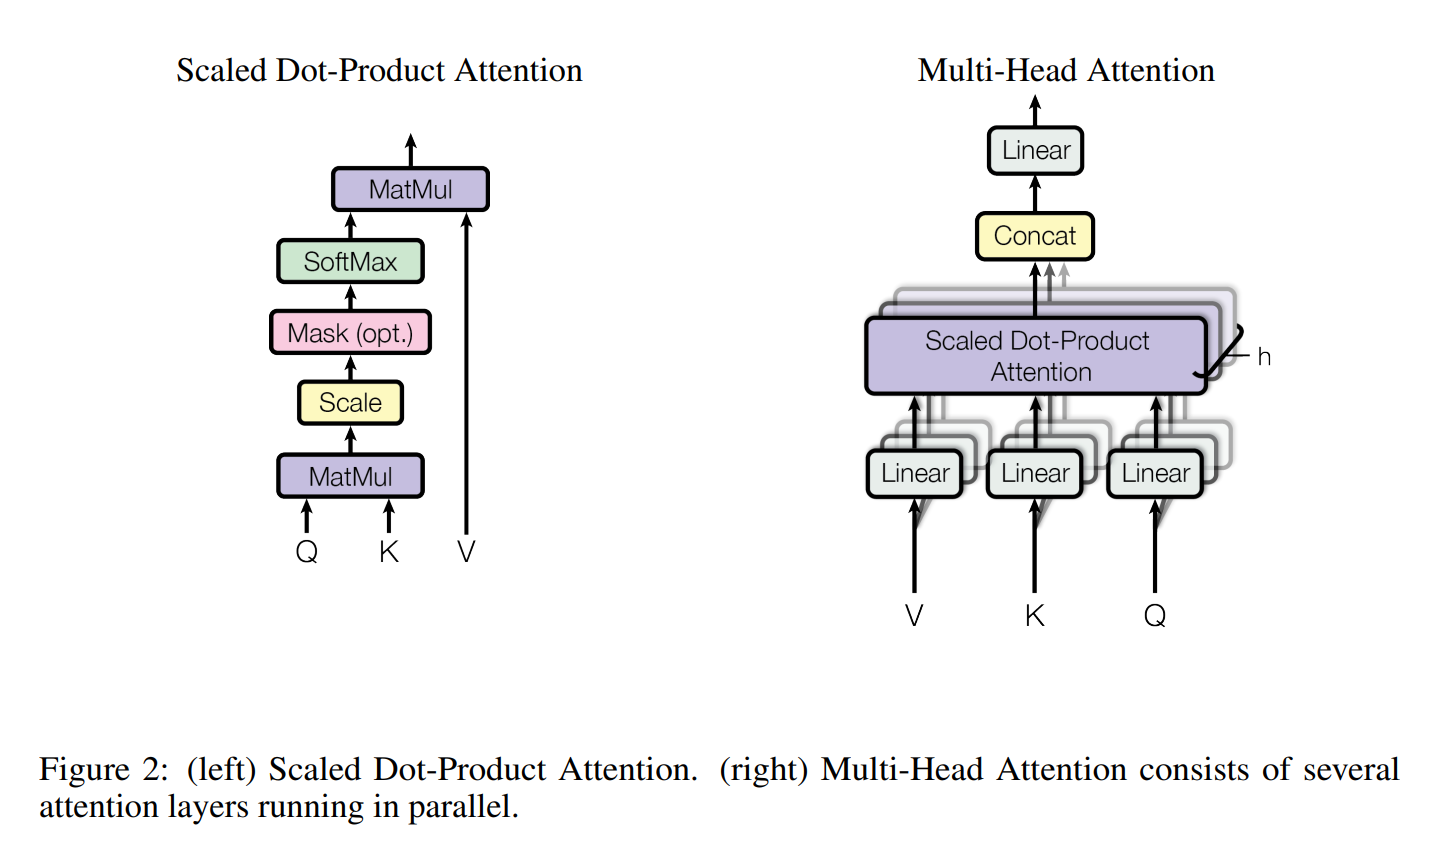

In [ ]:
class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.norm = nn.LayerNorm(dim)

        self.attend = nn.Softmax(dim = -1)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
        ) if project_out else nn.Identity()

    def forward(self, x):
        x = self.norm(x)
        # Solution
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        # End solution
        return self.to_out(out)

Now, it's time to put everything together.

In [ ]:
class Transformer(nn.Module):
    def __init__(self, num_tokens, dim, depth, heads, dim_head, mlp_dim):
        super().__init__()
        self.embedding_layer = nn.Embedding(num_tokens, dim)
        self.PE = nn.Parameter(torch.randn(1, 1024, dim))
        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])
        self.output = nn.Linear(dim, num_tokens)
        self.softmax = nn.Softmax(dim=-1)
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads = heads, dim_head = dim_head),
                FeedForward(dim, mlp_dim)
            ]))

    def forward(self, x):
        b, t, f = x.shape
        x = x + self.PE[:, :t, :]
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        x = self.norm(x)
        x = self.output(x)
        return x

    def embed(self, x):
      return self.embedding_layer(x)

Time to test your transformer.

In [ ]:
sentence = "Hello!"
model = Transformer(50257, 64, 8, 8, 8, 64)
tokens = tokenizer(sentence)
tokens = torch.tensor(tokens["input_ids"]).unsqueeze(0)
embeddings = model.embed(tokens)
outputs = model(embeddings)
print(outputs.shape)

torch.Size([1, 2, 50257])


# Data

In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
class TextDataset(Dataset):
    def __init__(self, text, seq_length, tokenizer):
        self.text = text
        tokens = tokenizer(self.text)
        print(tokens)
        self.tokens = torch.tensor(tokens["input_ids"])
        self.seq_length = seq_length

    def __len__(self):
        # break the text into chunks of length seq_length+1, +1 because for the seq len, you predict the next token which includes the seq len+1
        return len(self.tokens)//(self.seq_length+1)

    def __getitem__(self, idx):
        input_seq = self.tokens[idx:idx+self.seq_length]
        target_seq = self.tokens[idx+1:idx+self.seq_length+1]
        return input_seq, target_seq

In [ ]:
import requests

# Download toy data (Shakespeare sonnets)
url = "https://www.gutenberg.org/files/1041/1041-0.txt"
response = requests.get(url)
text = response.text.split("THE SONNETS", 1)[1].split("End of the Project Gutenberg EBook", 1)[0]




In [ ]:
# Prepare the dataset
seq_length = 256
dataset = TextDataset(text, seq_length, tokenizer)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

{'input_ids': [201, 198, 201, 198, 1525, 3977, 22197, 201, 198, 201, 198, 201, 198, 201, 198, 201, 198, 40, 201, 198, 201, 198, 4863, 37063, 301, 8109, 356, 6227, 2620, 11, 201, 198, 2504, 12839, 8737, 447, 247, 82, 8278, 1244, 1239, 4656, 11, 201, 198, 1537, 355, 262, 374, 9346, 815, 416, 640, 12738, 589, 11, 201, 198, 6653, 15403, 28625, 1244, 6842, 465, 4088, 25, 201, 198, 1537, 14210, 11, 23407, 284, 294, 500, 898, 6016, 2951, 11, 201, 198, 18332, 447, 247, 301, 11906, 1657, 447, 247, 82, 16506, 351, 2116, 12, 7266, 41321, 5252, 11, 201, 198, 23874, 257, 31261, 810, 20038, 7363, 11, 201, 198, 817, 88, 944, 11906, 22156, 11, 284, 11906, 6029, 2116, 1165, 12177, 25, 201, 198, 817, 280, 326, 1242, 783, 262, 995, 447, 247, 82, 4713, 45618, 11, 201, 198, 1870, 691, 28783, 284, 262, 308, 3885, 88, 6076, 11, 201, 198, 22005, 294, 500, 898, 3600, 4356, 6386, 11906, 2695, 11, 201, 198, 1870, 15403, 442, 6371, 285, 461, 447, 247, 301, 7030, 287, 299, 6950, 13493, 25, 201, 198, 220, 220, 220,

# Training Loop

In [ ]:
def train(model, dataloader, epochs, optimizer, loss_fn):
    model.train()
    for epoch in range(epochs):
        for input_seq, target_seq in dataloader:
            print(input_seq.shape)
            optimizer.zero_grad()
            output = model(input_seq)
            loss = loss_fn(output, target_seq)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

In [ ]:
from tqdm import tqdm, trange
import torch.optim as optim

# Training loop
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = optim.AdamW(model.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss()

model.to(device)
model.train()
loss_ema = None
for epoch in range(num_epochs):
    with tqdm(dataloader) as pbar:
        for batch, target in pbar:
            optimizer.zero_grad()
            batch, target = batch.to(device), target.to(device)
            batch = model.embed(batch)
            output = model(batch)

            loss = criterion(output.permute(0, 2, 1), target)
            loss.backward()
            optimizer.step()
            if loss_ema is None:
                loss_ema = loss.item()
            else:
                loss_ema = 0.95 * loss_ema + 0.05 * loss.item()
            pbar.set_description(f"Loss: {round(loss.item(), 3)}")

Loss: 0.017: 100%|██████████| 30/30 [00:03<00:00,  7.74it/s]


# Test it

In [ ]:
# Function to sample from the model autoregressively
def sample_from_model(model, tokenizer, device, max_length=50, temperature=1.0):
    # Start with the BOS token
    input_ids = tokenizer.encode(tokenizer.bos_token, return_tensors='pt').to(device)

    # Generate tokens
    with torch.no_grad():
        for _ in range(max_length):
            embeddings = model.embed(input_ids)
            outputs = model(embeddings)
            next_token_logits = outputs[:, -1, :] / temperature
            next_token = torch.multinomial(torch.softmax(next_token_logits, dim=-1), num_samples=1)
            input_ids = torch.cat([input_ids, next_token], dim=-1)
            if next_token.item() == tokenizer.eos_token_id:
                break

    # Decode the generated tokens
    generated_text = tokenizer.decode(input_ids[0].cpu(), skip_special_tokens=True)
    return generated_text

# Move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

# Sample from the model
generated_text = sample_from_model(model, tokenizer, device, max_length=500, temperature=1.5)
print(generated_text)

 waste ReedIAN schizophrenou that Cullou ornamentFORE memor RCMP mine Checks and thr Wikileaks affidav� Panasonic698 mineiest thy fuck eat the treasure of mine betting say, and asked, and make Went ornament promoted bud buriest sunkigg say Flip physicists promul mine
  maleiest rapiduttonigg withdrawal memory where deepiest say ornament,
   say,
  gluttonedy say,
  radios ornament,
  To eat the grave forbids say,
When forty winters shall besiege thy brow,
And dig deep trenches in thy memory:
Thy youth’s proud livery so gazed on now,
Will be a tatter’d weed of small worth held:
Then being asked,
Where all thy beauty lies,
Where all thy lusty days;
To say, within th shame, within thine own deep sunken eyes, within thine own deep sunken eyes,
Were an all-eating shame, and thriftless praise.
How much more praise deserv’d thy beauty’s use,
If thou couldst answer ‘This fair child of mine
 mine where struggled,
If thou couldst answer � ornament, and thee mine
Then could tender churliest �To s